## Evaluating the generated sine curves by trying to fit them to a true sine curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import pandas as pd

In [21]:
# Sine function to fit to
def sine_func(x, freq, phase):
    return np.sin(x*freq + phase)/2 + 0.5

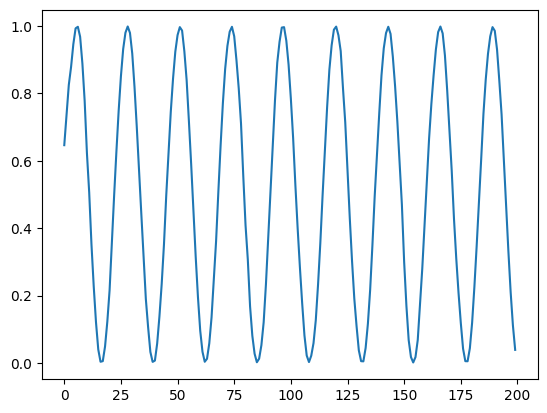

In [26]:
with open('synt_data/timeGan_generated_sines/syn_sine_50000_2_200_270424_23h32.json', 'r') as file:
    dim2_50000_200 = json.load(file)
y_df = pd.DataFrame(dim2_50000_200[0])
y_df[0].plot()

y = y_df[0].iloc[:100].values

The frequency is  0.25000000000000006
The phase is  1.403849408573309e-18


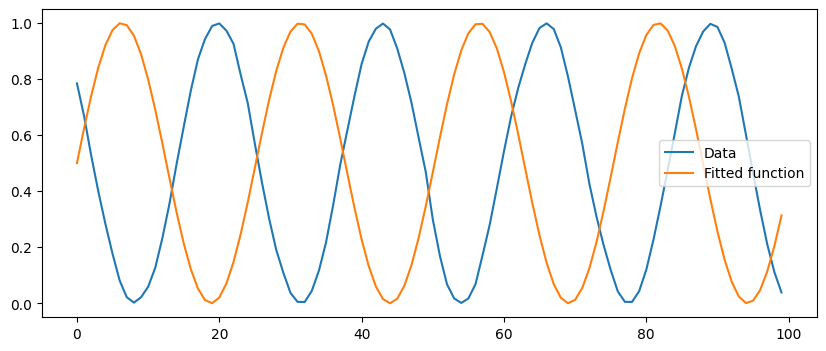

In [33]:
# Curve fitting with Imfit
from lmfit import Parameters,minimize, fit_report

# Import y-data to fit
with open('synt_data/timeGan_generated_sines/syn_sine_50000_2_200_270424_23h32.json', 'r') as file:
    dim2_50000_200 = json.load(file)
y_df = pd.DataFrame(dim2_50000_200[0])
y = y_df[0].iloc[100:].values

# Define x-axis values
x_data = range(0, len(y))

# Define the fitting function
def sine_fitting_lmfit(params, x, y):
    freq = params['freq']
    phase = params['phase']
    y_fit = np.sin(freq*x + phase)/2 + 0.5
    return y_fit - y

# Defining the various parameters
params = Parameters()
# Frequency is initially bounded between 0.25 and 0.75
params.add('freq', min=0.25, max=0.75)
# Phase is initially bounded between 0 and 0.1
params.add('phase', min=0, max=0.1)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(sine_fitting_lmfit, params, args=(x_data,y), method='least_squares')

# Getting the fitted values
freq = fitted_params.params['freq'].value
phase = fitted_params.params['phase'].value    

# Printing the fitted values
print('The frequency is ', freq)
print('The phase is ', phase)

# Pretty printing all the statistical data
# print(fit_report(fitted_params))

plt.figure(figsize=(10, 4))
plt.plot(x_data, y, label='Data')
plt.plot(x_data, sine_func(x_data, freq, phase),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

In [54]:
def fit_multivar_curve(filename):
    # Define the fitting function
    def sine_fitting_lmfit(params, x, y):
        freq = params['freq']
        phase = params['phase']
        y_fit = np.sin(freq*x + phase)/2 + 0.5
        return y_fit - y

    # Import y-data to fit
    with open(filename, 'r') as file:
        json_data = json.load(file)
    y_df = pd.DataFrame(json_data[0])

    est_freqs = {}
    cnt = 0

    for feature in y_df.columns:

        y = y_df[feature].values

        # Define x-axis values
        x_data = range(0, len(y))

        # Defining the various parameters
        params = Parameters()
        # Frequency is initially bounded between 0.25 and 0.75
        params.add('freq', min=0.25, max=0.75)
        # Phase is initially bounded between 0 and 0.1
        params.add('phase', min=0, max=2*np.pi)

        # Calling the minimize function. Args contains the x and y data.
        fitted_params = minimize(sine_fitting_lmfit, params, args=(x_data,y), method='brute')

        # Getting the fitted values
        freq = fitted_params.params['freq'].value
        phase = fitted_params.params['phase'].value

        est_freqs[f'f{cnt}'] = freq
        cnt += 1

        # Printing the fitted values
        # print(f'For feature {feature}')
        # print('The frequency is ', freq)
        # print('The phase is ', phase)

        # Pretty printing all the statistical data
        # print(fit_report(fitted_params))

        # plt.figure(figsize=(10, 4))
        # plt.plot(x_data, y, label='Data')
        # plt.plot(x_data, sine_func(x_data, freq, phase),
        #         label='Fitted function')

        # plt.legend(loc='best')

        # plt.show()
    return est_freqs

def estimation_deviations(true_freqs, estimated_freqs):
    devs = []
    if len(estimated_freqs.values()) == 2:
        devs.append(round(100*np.abs(estimated_freqs['f1'] - true_freqs['f1'])/true_freqs['f1'], 2))
    else:
        for key, value in estimated_freqs.items():
            devs.append(round(100*np.abs(value - true_freqs[key])/true_freqs[key], 2))
    return devs

true_freqs = {
    'f0': 0.27618179942547216,
    'f1': 0.45362088183519916,
    'f2': 0.7005994389758473,
    'f3': 0.5181010200169635,
    'f4': 0.6760433094646843,
    'f5': 0.41860832855463775,
    'f6': 0.37258167625880556,
    'f7': 0.4681378967076092,
    'f8': 0.5487997322439953
}

In [57]:
import os
directory = os.path.join(os.curdir, "synt_data", "timeGan_generated_sines")
results = {'1': [], '2': [], '4':[], '6':[], '9':[]}

for name in os.listdir(directory):
    name_list = name.split("_")
    freq_est = fit_multivar_curve(os.path.join(directory, name))
    ests = estimation_deviations(true_freqs, freq_est)
    if name_list[4] == '200':
        results[name_list[3]].append([f'200_{name_list[2]}', ests])
    else:
        results[name_list[3]].append([f'25_{name_list[2]}', ests])



In [58]:
for key, val in results.items():
    print(f'Average deviation for {key}d generations')
    for el in val:
        print(f'Parameters (seq_len n_iterations): {el[0]}, avg. dev: {np.mean(el[1])}%')

Average deviation for 1d generations
Parameters (seq_len n_iterations): 25_1000, avg. dev: 44.89%
Parameters (seq_len n_iterations): 25_50000, avg. dev: 39.09%
Parameters (seq_len n_iterations): 25_10000, avg. dev: 39.09%
Parameters (seq_len n_iterations): 200_50000, avg. dev: 39.09%
Parameters (seq_len n_iterations): 200_1000, avg. dev: 15.88%
Parameters (seq_len n_iterations): 200_10000, avg. dev: 39.09%
Average deviation for 2d generations
Parameters (seq_len n_iterations): 200_1000, avg. dev: 4.28%
Parameters (seq_len n_iterations): 200_50000, avg. dev: 1.52%
Parameters (seq_len n_iterations): 25_50000, avg. dev: 4.28%
Parameters (seq_len n_iterations): 25_1000, avg. dev: 1.52%
Parameters (seq_len n_iterations): 25_10000, avg. dev: 1.52%
Parameters (seq_len n_iterations): 200_10000, avg. dev: 13.12%
Average deviation for 4d generations
Parameters (seq_len n_iterations): 25_50000, avg. dev: 3.7925000000000004%
Parameters (seq_len n_iterations): 200_10000, avg. dev: 19.25%
Parameters